# Making Predictions

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates

from statsmodels.tsa.ar_model import AutoReg
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

##  Getting all the datasets

In [176]:
# importing the prediction data
df_pred = pd.read_csv('../clean_data/predictions.csv')

# lets rename columns for easy use
df_pred.rename(columns={"Unnamed: 0": "date" , "7dayrollingavg_newlyconfirmed":"7D_roll_pred", 'County':'county'},inplace = True)

# lets reset the index to county
df_pred.set_index('county', inplace= True)

# import data wise california vaccine allocation

df_vacc_alloc = pd.read_csv('../clean_data/vaccine_population.csv')
df_vacc_alloc = df_vacc_alloc[df_vacc_alloc['jurisdiction'] == 'California']
df_vacc_alloc.drop(columns=['2019_population','hhs_region','total_first_allocation' ], inplace = True)

# importing vaccination adminstration  data
df_vacc_admin = pd.read_csv('../clean_data/scrapped_ca_vaccine.csv')

# importing county population data
df_county_pop = pd.read_csv('../clean_data/cases_with_mask_use.csv')

# get county and population information only
df_county_pop = pd.DataFrame(df_county_pop.groupby(by = 'county')['population'].max())


##  EDA on county population

In [226]:
df_county_pop.head()

,population,ratio_county_pop,joinkey
county,,,
Alameda,1671329,0.042299,0
Alpine,1129,0.000029,0
Amador,39752,0.001006,0
Butte,219186,0.005547,0
Calaveras,45905,0.001162,0


In [229]:
# Lets create a column that gives the county population ratio to California pop
# of county population to total california population. We will use this for dosage distribution
df_county_pop['ratio_county_pop'] = (df_county_pop['population']/ df_county_pop['population'].sum())
df_county_pop.reset_index(inplace= True)

## EDA on prediction data

In [178]:
# lets look at the data
df_pred.head()
# '2021-02-14'

,date,7D_roll_pred
county,,
Alameda,2020-09-27,5.572982
Alameda,2020-09-28,5.402031
Alameda,2020-09-29,5.419126
Alameda,2020-09-30,4.726777
Alameda,2020-10-01,4.367782


## EDA on vaccination Adminstration data

In [253]:
df_vacc_admin

,state,date,total_doses_distributed,total_doses_administered,doses_dist_7roll,doses_admin_7roll,joinkey
0,California,2021-01-16,3548575,1072959,830925,560916,0
1,California,2021-01-17,3548575,1072959,1166050,730720,0
2,California,2021-01-18,3548575,1072959,1357950,935261,0
3,California,2021-01-19,3548575,1072959,1357950,1126949,0
4,California,2021-01-20,3548575,1072959,1357950,1257674,0
5,California,2021-01-21,4169450,1532329,849820,993356,0
6,California,2021-01-22,4379500,1633875,749364,1102283,0
7,California,2021-01-23,4714625,1803679,520769,1159592,0
8,California,2021-01-24,4906525,2008220,432421,1200119,0
9,California,2021-01-25,4906525,2199908,533079,1272874,0


In [179]:
# lets look at the data
df_vacc_admin = df_vacc_admin[df_vacc_admin['state']=='California'][['state' , 'date' ,'total_doses_distributed','total_doses_administered']]
df_vacc_admin["date"]= pd.to_datetime(df_vacc_admin["date"]) 

#### Two steps to be added for this
#### Step 1: need to expand the data till 2021-02-14
#### Step 2: need to roll up the data for 7 day ahead. i.e 2021-01-16 should be summed up for 6 days ahead.
#### Step 3: need to split up the data for each county by date.



### Step 1: need to expand the data till 2021-02-14

In [180]:
# function to get the next values based on AutoReg Time Series
def autoreg_dist(df):
    data = df['total_doses_distributed']
    model = AutoReg(data, lags=1)
    model_fit = model.fit()
    y = model_fit.predict(len(data), len(data))
    return round(y)

In [182]:
# function to get the next values based on AutoReg Time Series
def autoreg_admin(df):
    data = df['total_doses_administered']
    model = AutoReg(data, lags=1)
    model_fit = model.fit()
    y = model_fit.predict(len(data), len(data))
    return round(y)

In [183]:
max_dt = df_vacc_admin['date'].max()
for i in range(1,29):
    lst_dict = []
    lst_dict.append(    {   'state': 'California',
                            'date': max_dt,
                            'total_doses_distributed' : int(autoreg_dist(df_vacc_admin)),
                            'total_doses_administered' :int(autoreg_admin(df_vacc_admin))
                           })
    df_vacc_admin = df_vacc_admin.append(pd.DataFrame(lst_dict), ignore_index=True )
    max_dt = max_dt + dt.timedelta(days=1)




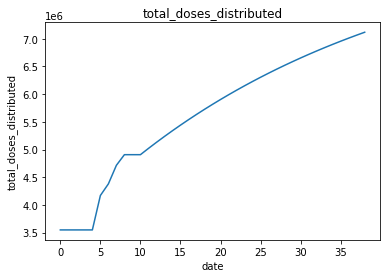

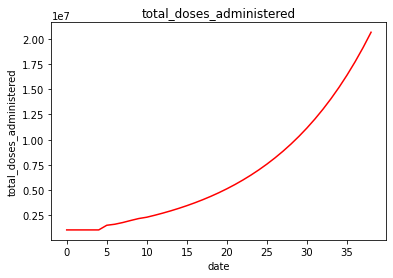

In [184]:


# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(df_vacc_admin.index, df_vacc_admin['total_doses_distributed'])
plt.title('total_doses_distributed')
plt.ylabel('total_doses_distributed');
plt.xlabel('date');
plt.show()

# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(df_vacc_admin.index, df_vacc_admin['total_doses_administered'] , 'r')
plt.title('total_doses_administered')
plt.ylabel('total_doses_administered');
plt.xlabel('date');
plt.show()



### Step 2: need to roll up the data for 7 day ahead. i.e 2021-01-16 should be summed up for 6 days ahead.

In [207]:
# lets create new column that is the cumulative 7 days for doses adminstered and doses distributed

df_vacc_admin['doses_dist_7roll'] = 0
df_vacc_admin['doses_admin_7roll'] = 0
for i in range(0,32):
    df_vacc_admin['doses_dist_7roll'][i]= df_vacc_admin['total_doses_distributed'][i+6]- df_vacc_admin['total_doses_distributed'][i]
    df_vacc_admin['doses_admin_7roll'][i]= df_vacc_admin['total_doses_administered'][i+6]- df_vacc_admin['total_doses_administered'][i]
    

### Step 3: Need to split the data by county

In [230]:
df_county_pop.head()

,county,population,ratio_county_pop,joinkey
0,Alameda,1671329,0.042299,0
1,Alpine,1129,0.000029,0
2,Amador,39752,0.001006,0
3,Butte,219186,0.005547,0
4,Calaveras,45905,0.001162,0


In [224]:
df_vacc_admin.head()

,state,date,total_doses_distributed,total_doses_administered,doses_dist_7roll,doses_admin_7roll,joinkey
0,California,2021-01-16,3548575,1072959,830925,560916,0
1,California,2021-01-17,3548575,1072959,1166050,730720,0
2,California,2021-01-18,3548575,1072959,1357950,935261,0
3,California,2021-01-19,3548575,1072959,1357950,1126949,0
4,California,2021-01-20,3548575,1072959,1357950,1257674,0


In [251]:
# lets do a cross join and merge the data sets for county and county population ratio. 
# this will help us to divide the doses admininstered and doses distributed 7 days cumulative by county

# since we have to do a cross join on two data frames that donot have a Key, lets create a key that is same.
df_county_pop['joinkey'] = 0
df_vacc_admin['joinkey'] = 0

# lets merge the vaccine and county population data together
df_county_vacc_dist_admin_7Droll = pd.merge(df_vacc_admin, df_county_pop, on="joinkey" , how="outer")

# selecting only the columns we need
df_county_vacc_dist_admin_7Droll = df_county_vacc_dist_admin_7Droll[['county' ,'date','doses_dist_7roll','doses_admin_7roll', 'ratio_county_pop']]

# rounding the county distribution and adminstration numbers
df_county_vacc_dist_admin_7Droll['doses_dist_7roll_county'] = round(df_county_vacc_dist_admin_7Droll['doses_dist_7roll'] * df_county_vacc_dist_admin_7Droll['ratio_county_pop'])
df_county_vacc_dist_admin_7Droll['doses_admin_7roll_county'] = round(df_county_vacc_dist_admin_7Droll['doses_admin_7roll'] * df_county_vacc_dist_admin_7Droll['ratio_county_pop'])

# selecting only the columns we needed
df_county_vacc_dist_admin_7Droll=df_county_vacc_dist_admin_7Droll[['county', 'date', 'doses_dist_7roll_county' , 'doses_admin_7roll_county' ]]

In [252]:
# final data set for Vaccine Adminstraion and Distribution by County and Date
df_county_vacc_dist_admin_7Droll

,county,date,doses_dist_7roll_county,doses_admin_7roll_county
0,Alameda,2021-01-16,35147.0,23726.0
1,Alpine,2021-01-16,24.0,16.0
2,Amador,2021-01-16,836.0,564.0
3,Butte,2021-01-16,4609.0,3112.0
4,Calaveras,2021-01-16,965.0,652.0
...,...,...,...,...
2257,Tulare,2021-02-22,0.0,0.0
2258,Tuolumne,2021-02-22,0.0,0.0
2259,Ventura,2021-02-22,0.0,0.0
2260,Yolo,2021-02-22,0.0,0.0


### EDA on vaccination dosage

In [160]:
df_vacc_alloc

,jurisdiction,doses_allocated_12_14,doses_allocated_12_21,doses_allocated_12_28,doses_allocated_01_04,doses_allocated_01_10,doses_allocated_01_18,doses_allocated_01_25
4,California,327600,905625,529675,463450,465325,485800,485800


In [161]:
# lets transpose the vacc_alloc data set so that we have by date doses allocation
df_vacc_alloc = df_vacc_alloc.T

In [162]:
# lets rename the column for dosage appropriatly 
df_vacc_alloc.rename(columns= {4:'dosage_alloc'}, inplace = True)

In [163]:
# lets remove the first row
df_vacc_alloc.drop( ['jurisdiction'],axis = 0,inplace = True)

In [164]:
# reset the index
df_vacc_alloc.reset_index(inplace=True)
df_vacc_alloc = df_vacc_alloc.rename(columns = {'index':'date'})

In [165]:
# removing the doses_allocated text
df_vacc_alloc['date'] = df_vacc_alloc['date'].str.replace('doses_allocated_', '')

In [166]:
# replacing Underscore with a dash
df_vacc_alloc['date'] = df_vacc_alloc['date'].str.replace('_', '-')

In [167]:
# lets define a function to update the date
def update_date(in_df):
    cnt = len(in_df)
    for i in range(cnt):
            if (in_df['date'][i][:2:]) == '12':
                in_df['date'][i] = '2020-'+in_df['date'][i]
            else:
                in_df['date'][i] = '2021-'+in_df['date'][i]


In [168]:
# lets update the date 
update_date(df_vacc_alloc)

In [169]:
# take a look at the data
df_vacc_alloc

,date,dosage_alloc
0,2020-12-14,327600
1,2020-12-21,905625
2,2020-12-28,529675
3,2021-01-04,463450
4,2021-01-10,465325
5,2021-01-18,485800
6,2021-01-25,485800


In [47]:
df_vacc_alloc['date'].unique()

array(['2020-12-14', '2020-12-21', '2020-12-28', '2021-01-04',
       '2021-01-10', '2021-01-18', '2021-01-25'], dtype=object)

### Merge data sets together

#### create a dataframe that has County, Date, Prediction, County population, vaccine allocation

In [49]:
# lets add population to predictions 
final =  pd.merge(df_pred ,df_county_pop, on ='county' , how = 'left' )

In [50]:
final['date'].unique()

array(['2020-09-27', '2020-09-28', '2020-09-29', '2020-09-30',
       '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-04',
       '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08',
       '2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12',
       '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16',
       '2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20',
       '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24',
       '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28',
       '2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01',
       '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05',
       '2020-11-06', '2020-11-07', '2020-11-08', '2020-11-09',
       '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13',
       '2020-11-14', '2020-11-15', '2020-11-16', '2020-11-17',
       '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21',
       '2020-11-22', '2020-11-23', '2020-11-24', '2020-11-25',
       '2020-11-26', '2020-11-27', '2020-11-28', '2020-

In [30]:
# since the 7 day rolling average was based off 100K , we need to calculate actual number of 7 day new patients

final['7D_roll_pred_tot'] = np.round((final['7D_roll_pred'] * final['population'])/ 100_000)

NameError: name 'final' is not defined

In [216]:
# lets look at merged data
final[final['date'] >= '2021-01-26']


,date,7D_roll_pred,population,7D_roll_pred_tot
county,,,,
Alameda,2021-01-26,8.328146,1671329,139.0
Alameda,2021-01-27,8.905375,1671329,149.0
Alameda,2021-01-28,8.976390,1671329,150.0
Alameda,2021-01-29,8.986604,1671329,150.0
Alameda,2021-01-30,8.988692,1671329,150.0
...,...,...,...,...
Yuba,2021-02-10,19.384285,78668,15.0
Yuba,2021-02-11,19.384285,78668,15.0
Yuba,2021-02-12,19.384285,78668,15.0


### Append the 'county to population ratio' to merged data set.

In [209]:
# ratio of county population to total california population. We will use this for dosage distribution
df_county_pop['ratio_county_pop'] = (df_county_pop['population']/ df_county_pop['population'].sum())

In [218]:
final_2 = pd.merge(final, df_county_pop['ratio_county_pop'], on="county", how="left")

In [220]:
final_2

,date,7D_roll_pred,population,7D_roll_pred_tot,ratio_county_pop
county,,,,,
Alameda,2020-09-27,5.572982,1671329,93.0,0.042299
Alameda,2020-09-28,5.402031,1671329,90.0,0.042299
Alameda,2020-09-29,5.419126,1671329,91.0,0.042299
Alameda,2020-09-30,4.726777,1671329,79.0,0.042299
Alameda,2020-10-01,4.367782,1671329,73.0,0.042299
...,...,...,...,...,...
Yuba,2021-02-10,19.384285,78668,15.0,0.001991
Yuba,2021-02-11,19.384285,78668,15.0,0.001991
Yuba,2021-02-12,19.384285,78668,15.0,0.001991


In [222]:
# use the ratio_county_pop to divide the dosage across county. Create a new column

#final_2['dosage_allocated_01_25'] = round(final_2['ratio_county_pop'] * 485800)

In [223]:
final_2['delta'] = final_2['dosage_allocated_01_25'] - final_2['7D_roll_pred_tot']

In [224]:
final_2

,date,7D_roll_pred,population,7D_roll_pred_tot,ratio_county_pop,dosage_allocated_01_25,delta
county,,,,,,,
Alameda,2020-09-27,5.572982,1671329,93.0,0.042299,20549.0,20456.0
Alameda,2020-09-28,5.402031,1671329,90.0,0.042299,20549.0,20459.0
Alameda,2020-09-29,5.419126,1671329,91.0,0.042299,20549.0,20458.0
Alameda,2020-09-30,4.726777,1671329,79.0,0.042299,20549.0,20470.0
Alameda,2020-10-01,4.367782,1671329,73.0,0.042299,20549.0,20476.0
...,...,...,...,...,...,...,...
Yuba,2021-02-10,19.384285,78668,15.0,0.001991,967.0,952.0
Yuba,2021-02-11,19.384285,78668,15.0,0.001991,967.0,952.0
Yuba,2021-02-12,19.384285,78668,15.0,0.001991,967.0,952.0


In [ ]:
## Approach to solve the problem
## Step1: create a function that inputs the dosage allocated to California and the Date
## Step2: calculate the dosage for that week
## Step 3: Output the dataframe with County, Week,  County infection population, Dosage allocated, Shortfall


### Append the 'county to population ratio' to merged data set.

In [ ]:
def pred_dosage(dosage, week_dt):
    dsge = int(dosage)
    dt = week_dt

    